In [3]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os import listdir

set1_dir = "../images/set1/"
set2_dir = "../images/set2/"
set3_dir = "../images/set3/"

set1_images = [np.array(cv2.imread(set1_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set1_dir))]
set2_images = [np.array(img.imread(set2_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set2_dir))]
set3_images = [np.array(img.imread(set3_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set3_dir))]

In [4]:
def imregionalmax(image, kernel=None):
    """Find the regional max of the image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - kernel: the size of the neiborhood region, default is 3x3, i.e.
              neighboring 8 pixels.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = cv2.dilate(image, kernel)
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = cv2.erode(image, kernel)
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [5]:
def est_homography(src, dest):
    """ Compute the homography matrix from (x_src, y_src) to (x_dest, y_dest).
    Parameters:
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    - dest: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
            so the matrix has dimension Nx2 (N>=4).
    Returns:
    - the homography matrix such that H @ [x_src, y_src, 1].T = [x_dest, y_dest, 1].T
    Author:
    - Yu Fang
    """
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    # take the right singular vector x corresponding to the least singular value
    # s.t. ||Ax - 0||^2 is minimized
    return V.T[:, 8].reshape(3, 3)

In [6]:
def apply_homography(H, src):
    """ Apply the homography H to src
    Parameters:
    - H: the 3x3 homography matrix
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Returns:
    - src: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Author:
    - Yu Fang
    """
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [7]:
def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    """A wrapper around OpenCV's drawMatches.
    
    Parameters:
    - image1: the first image
    - kp1: *matrix indices* of the keypoints from image 1
           (Nx2 numpy array, where N is the number of keypoints)
    - image2: the second image
    - kp2: *matrix indices* of the keypoints from image 2 
           (Nx2 numpy array, where N is the number of keypoints)
    - idx_pairs: pairs of matching indices, e.g. if kp1[3] 
                 matches kp2[5], then idx_pairs=[[3,5],...]
                 (Kx2 numpy array, where K is the number of matches)
    Returns:
    - an image showing matching points
    Author:
    - Yu Fang
    """
    # note that the coordinates are reversed because the difference
    # between matrix indexing & coordinates.
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [8]:
# homography example (TODO remove this block in the final submission)
src = np.array([
    [0, 0],
    [3, 0],
    [0, 2],
    [3, 2]
])
dest = np.array([
    [10, 10],
    [13, 10],
    [12, 12],
    [15, 12]
])

H = est_homography(src, dest)
print(f"H:\n{H}")
dest2 = apply_homography(H, src)
print(f"recover dest:\n{dest2}")

H:
[[-7.00140042e-02 -7.00140042e-02 -7.00140042e-01]
 [ 4.33338378e-15 -7.00140042e-02 -7.00140042e-01]
 [ 4.53873313e-16  8.07299370e-17 -7.00140042e-02]]
recover dest:
[[10. 10.]
 [13. 10.]
 [12. 12.]
 [15. 12.]]


In [9]:
def amns(C, n_best):
    '''
    Adaptive Non-Maximal Suppression
    '''
    # Obtain local maxima of C
    local_maxima = imregionalmax(C)
    # Find the (x,y) coordinates for the local maxima
    coords = np.array([[row, col] for row in range(0, local_maxima.shape[0]) for col in range(0, local_maxima.shape[1]) if local_maxima[row, col] == 1])
    r = {}
    for c in coords:
        r[tuple(c)] = np.inf
    # For each local maxima, check the corner response relative to every other corner 
    c_robust = 0.9
    C_scaled = c_robust * C
    for c in coords:
        # Obtain the list of suppressing points
        suppressing_points = np.array(np.where(C[c[0], c[1]] < C_scaled)).T
        
        # Calculate distances from current points to supressing points
        distances = np.sum(np.abs(suppressing_points - np.array([c[0], c[1]])), axis=1)

        # Update the minimum distance for the current point
        r[tuple(c)] = np.sort(distances)[0] if len(distances) > 0 else r[tuple(c)]

    return np.array([c[0] for c in sorted(r.items(), key=lambda t: t[1], reverse=True)][:n_best])

In [10]:
# Obtain feature points for set1 images
set1_feature_points = []
strongest_corners = 500
block_size = 4
k_size = 3
k = 0.04
for im in set1_images:
    set1_feature_points.append(amns(cv2.cornerHarris(im, block_size, k_size, k), strongest_corners))


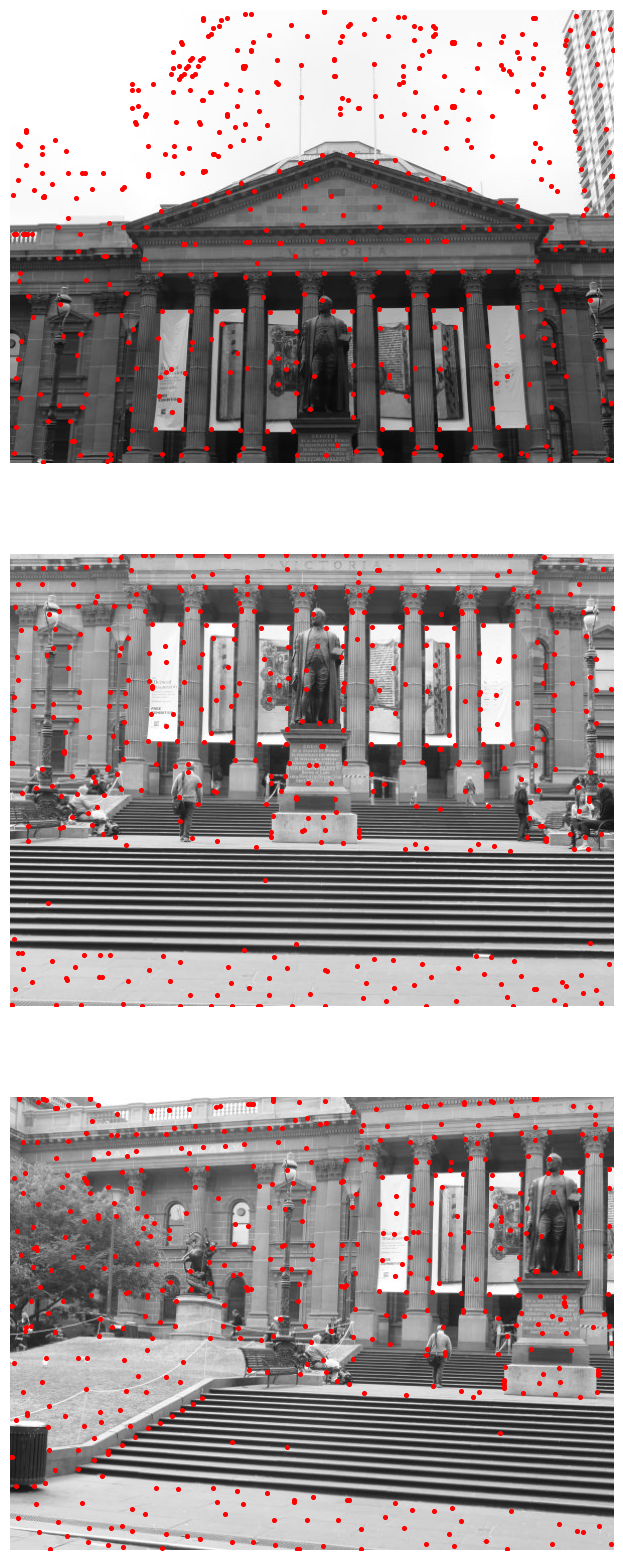

In [11]:
fig = plt.figure(figsize=(50,20))
for i in range(len(set1_images)):
    fig.add_subplot(3,1,i + 1)
    plt.imshow(cv2.cvtColor(set1_images[i], cv2.COLOR_BGR2RGB))
    plt.scatter(set1_feature_points[i][:, 1], set1_feature_points[i][:, 0], c='r', s=7)
    plt.axis("off")


In [12]:
def get_feature_descriptors(x_best, y_best, image):
    '''
    Get feature descriptors (feature vector) from the feature points (N best corners after AMNS)
    '''
    # Get the number of keypoints
    n_best = len(x_best)
    descriptor = {}
    #padd the imange with 0's for patch extractions
    image_padded = np.pad(image, (20, 20), 'constant') 
    i = 0
    for indx in range(n_best):
    
        # Get coordinates of the current keypoint
        y = x_best[indx]
        x = y_best[indx]
        y_padded = y+20
        x_padded = x+20

        patch_padded = image_padded[y_padded-20:y_padded+20, x_padded-20:x_padded+20]
       
        # Apply Gaussian blur to the patch
        sig = 1
        blurred = cv2.GaussianBlur(patch_padded,(5,5), sig)
        
        # Resize the blurred patch to 8x8
        resized = cv2.resize(blurred, dsize=(8, 8), interpolation=cv2.INTER_LANCZOS4)
        # Reshape the patch to a column vector
        reshaped = resized.reshape(-1, 1)
        # Standardize the patch
        mean_reshaped = np.mean(reshaped)
        std_dev = np.std(reshaped)
        standardized = (reshaped - mean_reshaped) / std_dev

        # Store the standardized patch as a column in the descriptors matrix
        descriptor[(x,y)]  = standardized.ravel()
    return np.array([(c[0], c[1]) for c in list(descriptor.items())], dtype=object)

In [13]:
set1_feature_descriptors = []
i = 0
# Obtain feature points and descriptors for each image
for image in set1_images:
  
    
    xBest = [point[0] for point in set1_feature_points[i]]
    yBest = [point[1] for point in set1_feature_points[i]]
  
    # Obtain feature descriptors using descriptors function
    set1_feature_descriptor = get_feature_descriptors(xBest,yBest, image)
    # Append feature descriptors to the list
    set1_feature_descriptors.append(set1_feature_descriptor)
   
    i += 1

In [14]:
# TODO Add parameters

def feature_matching():
    '''
    Match feature 
    '''
    # TODO Add code here
    return

In [15]:
# TODO Add code to perform feature matching

In [16]:
# TODO Add parameters
def ransac():
    '''
    Random Sampling Concensus
    '''
    # TODO Add code here
    return

In [17]:
# TODO Add code to perform ransac

In [18]:
# TODO Add parameters
def blend_images():
    '''
    Blends images
    '''
    # TODO Add code here
    return

In [19]:
# TODO Add code to perform image blending